## Bayesian AGN Decomposition Analysis for SDSS Spectra (BADASS)
### Example: LVS Rodeo Cube Example

This example showcases how to fit a general IFU cube.  The data is a subcube of a much larger MUSE cube of NGC 1386.  The data and fitting was showcased at [Large-Volume Spectroscopic Analyses of AGN and Star Forming Galaxies in the Era of JWST](https://www.stsci.edu/contents/events/stsci/2022/march/large-volume-spectroscopic-analyses-of-agn-and-star-forming-galaxies-in-the-era-of-jwst) workshop at STScI.

####  Remington O. Sexton$^{1}$, Sara M. Doan$^{2}$, William Matzko$^{2}$ Michael A. Reefe$^{2}$, 
$^{1}$United States Naval Observatory, $^{2}$George Mason University

In [8]:
import glob
import time
import natsort
from IPython.display import clear_output
import os
import sys
import psutil
import pathlib
import natsort
# Import BADASS here
BADASS_DIR = pathlib.Path(os.getcwd()).resolve().parent
sys.path.insert(1,str(BADASS_DIR))
import badass as badass
import badass_check_input
import badass_ifu as ifu

from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

### BADASS Options

In [16]:
################################## Fit Options #################################
# Fitting Parameters
fit_options={
"fit_reg"    : (18300, 19600),# Fitting region; Note: Indo-US Library=(3460,9464)
"good_thresh": 0.0, # percentage of "good" pixels required in fig_reg for fit.
"mask_bad_pix": False, # mask pixels SDSS flagged as 'bad' (careful!)
"mask_emline" : False, # automatically mask lines for continuum fitting.
"mask_metal": False, # interpolate over metal absorption lines for high-z spectra
"fit_stat": "ML", # fit statistic; ML = Max. Like. , OLS = Ordinary Least Squares
"n_basinhop": 25, # Number of consecutive basinhopping thresholds before solution achieved
"test_lines": False, # Perform line/configuration testing for multiple components
"max_like_niter": 25, # number of maximum likelihood iterations
"output_pars": False, # only output free parameters of fit and stop code (diagnostic)
"cosmology": {"H0":70.0, "Om0": 0.30}, # Flat Lam-CDM Cosmology
}
################################################################################

########################### MCMC algorithm parameters ##########################
mcmc_options={
"mcmc_fit"    : False, # Perform robust fitting using emcee
"nwalkers"    : 100,  # Number of emcee walkers; min = 2 x N_parameters
"auto_stop"   : False, # Automatic stop using autocorrelation analysis
"conv_type"   : "all", # "median", "mean", "all", or (tuple) of parameters
"min_samp"    : 1000,  # min number of iterations for sampling post-convergence
"ncor_times"  : 10.0,  # number of autocorrelation times for convergence
"autocorr_tol": 10.0,  # percent tolerance between checking autocorr. times
"write_iter"  : 100,   # write/check autocorrelation times interval
"write_thresh": 100,   # iteration to start writing/checking parameters
"burn_in"     : 1500, # burn-in if max_iter is reached
"min_iter"    : 1000, # min number of iterations before stopping
"max_iter"    : 2500, # max number of MCMC iterations
}
################################################################################

############################ Fit component op dtions #############################
comp_options={
"fit_opt_feii"     : False, # optical FeII
"fit_uv_iron"      : False, # UV Iron 
"fit_balmer"       : False, # Balmer continuum (<4000 A)
"fit_losvd"        : True, # stellar LOSVD
"fit_host"         : False, # host template
"fit_power"        : False, # AGN power-law
"fit_poly"         : True, # Add polynomial continuum component
"fit_narrow"       : True, # narrow lines
"fit_broad"        : False, # broad lines
"fit_absorp"       : False, # absorption lines
"tie_line_disp"    : False, # tie line widths (dispersions)
"tie_line_voff"    : False, # tie line velocity offsets
}

# Line options for each narrow, broad, and absorption.
narrow_options = {
    #"amp_plim": (0.5,3), # line amplitude parameter limits; default (0,)
    "disp_plim": (0,500), # line dispersion parameter limits; default (0,)
    "voff_plim": (-300,300), # line velocity offset parameter limits; default (0,)
    "line_profile": "gaussian", # line profile shape*
    "n_moments": 4, # number of higher order Gauss-Hermite moments (if line profile is gauss-hermite, laplace, or uniform)
}

broad_options ={
#     "amp_plim": (0,40), # line amplitude parameter limits; default (0,)
    "disp_plim": (0,300), # line dispersion parameter limits; default (0,)
    "voff_plim": (-300,300), # line velocity offset parameter limits; default (0,)
    "line_profile": "gaussian", # line profile shape*
    "n_moments": 4, # number of higher order Gauss-Hermite moments (if line profile is gauss-hermite, laplace, or uniform)
}

absorp_options = {
#     "amp_plim": (-1,0), # line amplitude parameter limits; default (0,)
#     "disp_plim": (0,10), # line dispersion parameter limits; default (0,)
#     "voff_plim": (-2500,2500), # line velocity offset parameter limits; default (0,)
    "line_profile": "gaussian", # line profile shape*
    "n_moments": 4, # number of higher order Gauss-Hermite moments (if line profile is gauss-hermite, laplace, or uniform)        
}

# Choices for line profile shape include 'gaussian', 'lorentzian', 'voigt',
# 'gauss-hermite', 'laplace', and 'uniform'
################################################################################

########################### Emission Lines & Options ###########################
# If not specified, defaults to SDSS-QSO Emission Lines (http://classic.sdss.org/dr6/algorithms/linestable.html)
################################################################################
# User lines overrides the default line list with a user-input line list!
user_lines = {
    "NA_PASCHEN_ALPHA"      :{"center":18750,"amp":"free","disp":"free","voff":"free","line_type":"na","ncomp":1,},
    "BR_PASCHEN_ALPHA"      :{"center":18750,"amp":"free","disp":"free","voff":"free","line_type":"br","ncomp":2,"parent":"NA_PASCHEN_ALPHA"},
    #"NA_BRACKET_GAMMA"      :{"center":21660,"amp":"free","disp":"free","voff":"free","line_type":"na","ncomp":1,},
    #"BR_BRACKET_GAMMA"      :{"center":21660,"amp":"free","disp":"free","voff":"free","line_type":"br","ncomp":2,"parent":"NA_BRACKET_GAMMA"},


}

configs = [
]


test_options = {
"test_mode":"line",
"lines": [["NA_PASCHEN_ALPHA"]], # The lines to test
#"metrics": ["CHI2_RATIO"],# Fitting metrics to use when determining the best model
#"thresholds": [0.25],
"metrics": ["BADASS", "ANOVA", "CHI2_RATIO","AON"],# Fitting metrics to use when determining the best model
"thresholds": [-1.0, -1.0, -1.0, 3.0],
"conv_mode": "any", # "any" single threshold satisfies the solution, or "all" must satisfy thresholds
"auto_stop":False, # automatically stop testing once threshold is reached; False test all no matter what
"full_verbose":False, # prints out all test fitting to screen
"plot_tests":True, # plot the fit of each model comparison
"force_best":True, # this forces the more-complex model to have a fit better than the previous.
"continue_fit":True, # continue the fit with the best chosen model
}

user_constraints = [
    ("BR_PASCHEN_ALPHA_DISP","NA_PASCHEN_ALPHA_DISP"),
    ("NA_PASCHEN_ALPHA_AMP","BR_PASCHEN_ALPHA_AMP"),
]
# User defined masked regions (list of tuples)
user_mask = [
#    (4920, 6400)
]

# Combined lines; define a composite line and calculate
# its combined parameters.  These are automatically
# generated for lines with multiple components (parent+child lines)
combined_lines = {
    # "H_BETA_COMP"   :["NA_H_BETA","BR_H_BETA"],
}
########################## LOSVD Fitting & Options #############################
# For direct fitting of the stellar kinematics (stellar LOSVD), one can 
# specify a stellar template library (Indo-US or Vazdekis 2010).
# One can also hold velocity or dispersion constant to avoid template
# convolution during the fitting process.
################################################################################

losvd_options = {
"library"   : "eMILES", # Options: IndoUS, Vazdekis2010
"vel_const" :  {"bool":False, "val":0.0},
"disp_const":  {"bool":False, "val":250.0},
}

########################## SSP Host Galaxy Template & Options ##################
# The default is zero velocity, 100 km/s dispersion 10 Gyr template from 
# the eMILES stellar library. 
################################################################################

host_options = {
"age"       : [1.0,5.0,10.0], # Gyr; [0.09 Gyr - 14 Gyr] 
"vel_const" : {"bool":False, "val":0.0},
"disp_const": {"bool":False, "val":150.0}
}

########################### AGN power-law continuum & Options ##################
# The default is a simple power law.
################################################################################

power_options = {
"type" : "simple" # alternatively, "broken" for smoothly-broken power-law
}

########################### Polynomial Continuum Options #######################
# Options for an additive legendre polynomial or multiplicative polynomial to be 
# included in the fit.  NOTE: these polynomials do not include the zeroth-order
# (constant) term to avoid degeneracies with other continuum components.
################################################################################

poly_options = {
"apoly" : {"bool": True , "order": 3}, # Legendre additive polynomial 
"mpoly" : {"bool": False, "order": 2}, # Legendre multiplicative polynomial 
}

############################### Optical FeII options ###############################
# Below are options for fitting optical FeII.  For most objects, you don't need to 
# perform detailed fitting on FeII (only fit for amplitudes) use the 
# Veron-Cetty 2004 template ('VC04') (2-6 free parameters)
# However in NLS1 objects, FeII is much stronger, and sometimes more detailed 
# fitting is necessary, use the Kovacevic 2010 template 
# ('K10'; 7 free parameters).

# The options are:
# template   : VC04 (Veron-Cetty 2004) or K10 (Kovacevic 2010)
# amp_const  : constant amplitude (default False)
# disp_const : constant dispersion (default True)
# voff_const : constant velocity offset (default True)
# temp_const : constant temp ('K10' only)

opt_feii_options={
"opt_template"  :{"type":"VC04"}, 
"opt_amp_const" :{"bool":False, "br_opt_feii_val":1.0   , "na_opt_feii_val":1.0},
"opt_disp_const":{"bool":False, "br_opt_feii_val":3000.0, "na_opt_feii_val":500.0},
"opt_voff_const":{"bool":False, "br_opt_feii_val":0.0   , "na_opt_feii_val":0.0},
}
# or
# opt_feii_options={
# "opt_template"  :{"type":"K10"},
# "opt_amp_const" :{"bool":False,"f_feii_val":1.0,"s_feii_val":1.0,"g_feii_val":1.0,"z_feii_val":1.0},
# "opt_disp_const":{"bool":False,"opt_feii_val":1500.0},
# "opt_voff_const":{"bool":False,"opt_feii_val":0.0},
# "opt_temp_const":{"bool":True,"opt_feii_val":10000.0},
# }
################################################################################

############################### UV Iron options ################################
uv_iron_options={
"uv_amp_const"  :{"bool":False, "uv_iron_val":1.0},
"uv_disp_const" :{"bool":False, "uv_iron_val":3000.0},
"uv_voff_const" :{"bool":True,  "uv_iron_val":0.0},
}
################################################################################

########################### Balmer Continuum options ###########################
# For most purposes, only the ratio R, and the overall amplitude are free paramters
# but if you want to go crazy, you can fit everything.
balmer_options = {
"R_const"          :{"bool":True,  "R_val":1.0}, # ratio between balmer continuum and higher-order balmer lines
"balmer_amp_const" :{"bool":False, "balmer_amp_val":1.0}, # amplitude of overall balmer model (continuum + higher-order lines)
"balmer_disp_const":{"bool":True,  "balmer_disp_val":5000.0}, # broadening of higher-order Balmer lines
"balmer_voff_const":{"bool":True,  "balmer_voff_val":0.0}, # velocity offset of higher-order Balmer lines
"Teff_const"       :{"bool":True,  "Teff_val":15000.0}, # effective temperature
"tau_const"        :{"bool":True,  "tau_val":1.0}, # optical depth
}

################################################################################

############################### Plotting options ###############################
plot_options={
"plot_param_hist"    : True,# Plot MCMC histograms and chains for each parameter
"plot_HTML"          : True,# make interactive plotly HTML best-fit plot
}
################################################################################

################################ Output options ################################
output_options={
"write_chain"  : False, # Write MCMC chains for all paramters, fluxes, and
                         # luminosities to a FITS table We set this to false 
                         # because MCMC_chains.FITS file can become very large, 
                         # especially  if you are running multiple objects.  
                         # You only need this if you want to reconstruct full chains 
                         # and histograms. 
"write_options": False,  # output restart file
"verbose"      : False,   # print out all steps of fitting process
}
################################################################################

#### Directory Structure: This is where IFU data will differ from fitting normal 1D spectra

In [17]:
########################## Directory Structure #################################

########################## Generic Example Fit ###################################
spec_dir = BADASS_DIR.joinpath("example_spectra/DualAGN/J1102/ifu","pa_alpha") # folder with spectra in it

# # Get full list of spectrum files - will make sub-directories when decomposing the IFU Cube(s), so it is assumed
# # that the cube FITS files are within spec_dir directly.
spec_loc = natsort.natsorted( glob.glob(str(spec_dir.joinpath('*.fits'))))
spec_loc = spec_loc[:]

################################################################################
print(len(spec_loc))
print(spec_loc)

1
['/Users/michaelmcdonald/Downloads/UCR/Lab/Gaby/Code/badass/BADASS3/example_spectra/DualAGN/J1102/ifu/pa_alpha/J1102_final.fits']


/Users/michaelmcdonald/Downloads/UCR/Lab/Gaby/Code/badass/BADASS3/example_spectra/DualAGN/J1102/ifu/pa_alpha/J1102_final.fits
Flux normalization (BUNIT) = ADU per second per coadd
Shape of input cube (nx,ny,nz) = (1665,64,19)


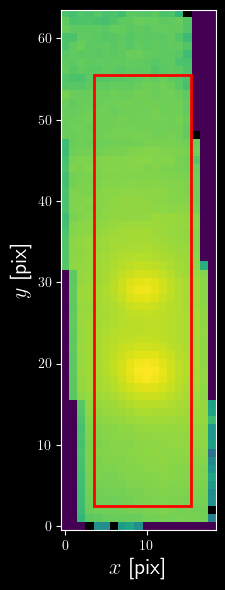

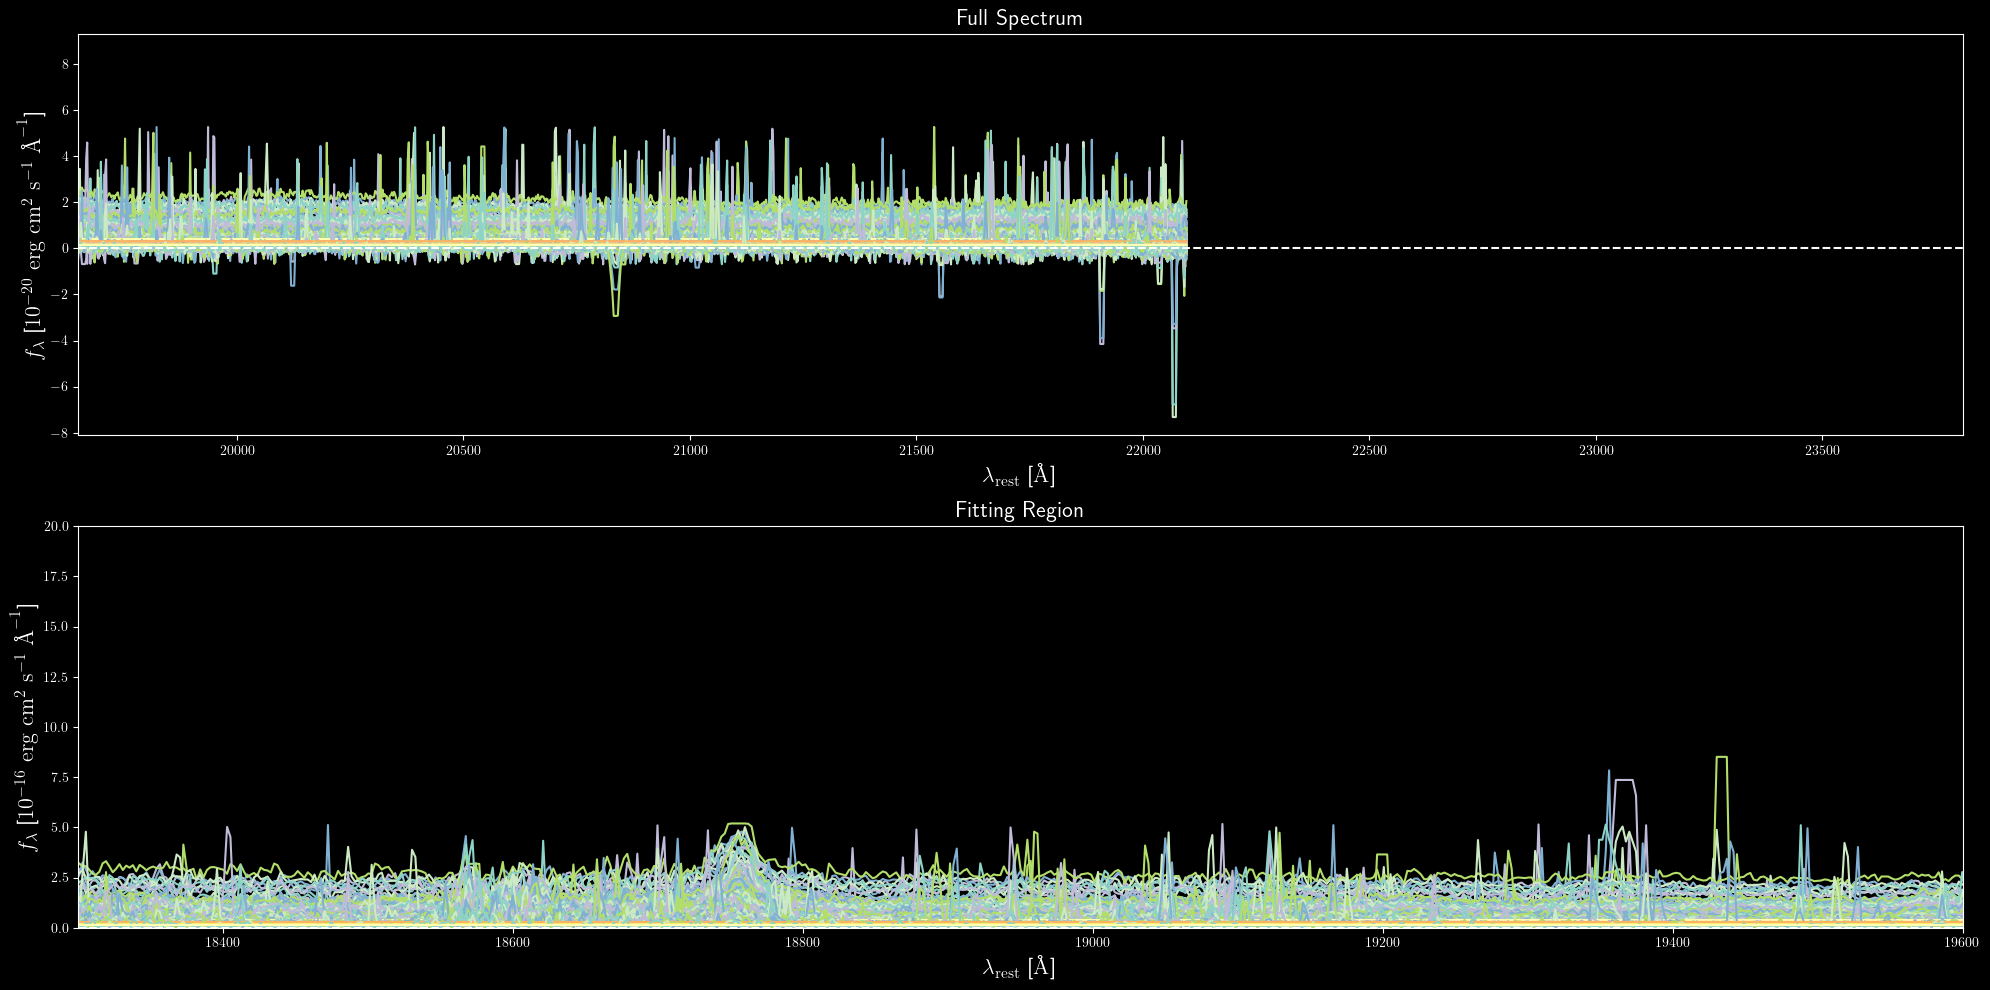

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy.io import fits

cube = spec_loc[0]
print(cube)
# Define an aperture [y1,y2,x1,x2]
#aperture = [1,60,1, 15]
#aperture = [33, 36, 7, 10]
#aperture = [9,15,13, 16]
aperture = [3,55,4, 15]
#aperture = [23, 38, 6, 13]
#aperture = [30, 38, 6, 13]
#aperture = [33, 38, 7, 12]

# Open the fits file
hdu = fits.open(spec_loc[0])
# hdu.info()
header = hdu[0].header
# display(header.cards)

# Define sizes of the cube
nx = header["NAXIS1"]
ny = header["NAXIS2"]
nz = header["NAXIS3"]

# NGC 1386 info from wikipedia
z  = 0.07757031 # redshift
ra, dec = 165.554209655, 64.990239373
# Define the wavelength axis
wave = np.linspace(19650, 23810, 1665)
# MUSE cubes are normalized by 1.e-20
flux_norm = 1e-18
print(f"Flux normalization (BUNIT) = %s" % header["BUNIT"]) # print flux normalization to double check
flux = (hdu[0].data) / flux_norm

flux = np.swapaxes(flux, 0, 2)

flux[flux > 15] = np.mean(flux)
flux[flux < -15] = np.mean(flux)
print(f"Shape of input cube (nx,ny,nz) = ({nx},{ny},{nz})")

# use a constant noise
#noise = np.full_like(flux,np.nanstd(flux[(wave>5240)&(wave<5300), :, :], axis = 0)) / 2
#noise = np.full_like(flux,np.nanstd(flux[(wave>7450)&(wave<7550), :, :], axis = 0)) / 2
#noise = np.full_like(flux,np.nanmedian(flux))
#noise = np.full_like(flux,0.5)
#noise = np.full_like(flux,np.nanmedian(flux, axis = 0)) / 10
#noise = np.full_like(flux,np.nanmedian(flux[:, 47,17]))
#noise = np.ones(np.shape(flux)) * 0.05

#var = np.abs(noise)**2
var = np.full_like(flux, np.nanvar(flux, axis = 0))
#print(np.max(var[1000, :, :]))
noise = np.sqrt(var)
# IFU data requires an inverse variance
ivar = 1.0/var
#ivar = np.ones(np.shape(flux))
specres =  1000 # spectral resolution R


# Plot the flattened 2D map
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)

flat = np.sum(flux,axis=0)
ax1.imshow(np.log(1000*flat+1)/np.log(1000),cmap="viridis",
          origin="lower")
# Draw the aperture
rect = patches.Rectangle((aperture[2]-0.5, aperture[0]-0.5), (aperture[3]-aperture[2]+1), (aperture[1]-aperture[0]+1), 
                         linewidth=2, edgecolor='r', facecolor='none')
ax1.add_patch(rect)

ax1.set_ylabel(r"$y$ [pix]",fontsize=16)
ax1.set_xlabel(r"$x$ [pix]",fontsize=16)
plt.tight_layout()

# Plot all the spectra included in the aperture
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
fontsize = 16

for x in range(aperture[0],aperture[1]+1,1):
    for y in range(aperture[2],aperture[3]+1,1):
        #print(f" Plotting spaxel ({x},{y})")
        ax1.plot(wave/(1+z),flux[:,x,y])
        ax1.plot(wave/(1+z),noise[:,x,y])
        ax2.plot(wave/(1+z),flux[:,x,y])
        ax2.plot(wave/(1+z),noise[:,x,y])
#
ax1.axhline(0.0,linestyle="--")
ax1.set_ylabel(r"$f_\lambda$ [$10^{-20}~\rm{erg}~\rm{cm}^2~\rm{s}^{-1}~\rm{\AA}^{-1}$]",fontsize=fontsize)
ax1.set_xlabel(r"$\lambda_{\rm{rest}}$ [$\rm{\AA}$]",fontsize=fontsize)
ax1.set_title(r"Full Spectrum",fontsize=fontsize)
ax1.set_xlim(np.min(wave), np.max(wave))
#
ax2.axhline(0.0,linestyle="--")
ax2.set_ylabel(r"$f_\lambda$ [$10^{-16}~\rm{erg}~\rm{cm}^2~\rm{s}^{-1}~\rm{\AA}^{-1}$]",fontsize=fontsize)
ax2.set_xlabel(r"$\lambda_{\rm{rest}}$ [$\rm{\AA}$]",fontsize=fontsize)
ax2.set_title(r"Fitting Region",fontsize=fontsize)
ax2.set_xlim(fit_options["fit_reg"][0], fit_options["fit_reg"][1])
ax2.set_ylim(0, 20)


plt.tight_layout()

### Unpack the cube into spaxels

In [20]:
# Unpack the spectra into 1D FITS files
print(f'Unpacking {cube} into subfolders...')
# The formats currently supported are 'muse' and 'manga'
wave,flux,ivar,mask,fwhm_res,binnum,npixels,xpixbin,ypixbin,z,dataid,objname = ifu.prepare_ifu(cube, z, 
                                                                               format='user', 
                                                                               nx=nz,
                                                                               ny=ny,
                                                                               nz=nx,
                                                                               ra=ra,
                                                                               dec=dec,
                                                                               wave=wave,
                                                                               flux=flux,
                                                                               ivar=ivar,
                                                                               specres=specres,
                                                                               aperture=aperture, 
                                                                               targetsn = 7.0 ,
                                                                               snr_threshold = 0.1,
                                                                               voronoi_binning= False,
#                                                                                 maxbins=500,
                                                                              )
# Plot the cube data
ifu.plot_ifu(cube, wave, flux, ivar, mask, binnum, npixels, xpixbin, ypixbin, z, dataid, aperture, objname)
# ifu.plot_ifu(cube, wave, flux, ivar, mask, binnum, npixels, xpixbin, ypixbin, z, dataid, objname)

cube_subdir = os.path.join(os.path.dirname(cube), cube.split(os.sep)[-1].replace('.fits','')) + os.sep
print(cube_subdir)



Unpacking /Users/michaelmcdonald/Downloads/UCR/Lab/Gaby/Code/badass/BADASS3/example_spectra/DualAGN/J1102/ifu/pa_alpha/J1102_final.fits into subfolders...
/Users/michaelmcdonald/Downloads/UCR/Lab/Gaby/Code/badass/BADASS3/example_spectra/DualAGN/J1102/ifu/pa_alpha/J1102_final/


### Fit

In [21]:
if __name__ == "__main__":

    badass.run_BADASS(cube_subdir,
                     nprocesses       = 4,
                     nobj             = (0,636),
                     fit_options      = fit_options,
                     mcmc_options     = mcmc_options,
                     comp_options     = comp_options,
                     test_options     = test_options,
                     # New line options
                     narrow_options   = narrow_options,
                     broad_options    = broad_options,
                     absorp_options   = absorp_options,
                     user_mask        = user_mask,
                     user_lines       = user_lines,
                     user_constraints = user_constraints,
                     combined_lines   = combined_lines,
                     losvd_options    = losvd_options,
                     host_options     = host_options,
                     power_options    = power_options,
                     poly_options     = poly_options,
                     opt_feii_options = opt_feii_options,
                     uv_iron_options  = uv_iron_options,
                     balmer_options   = balmer_options, 
                     plot_options     = plot_options,
                     output_options   = output_options,
                     sdss_spec        = False,
                     ifu_spec         = True,
                     flux_norm = flux_norm, # Don't forget to give it the flux normalization!
                     )

Fitting 636 1D spectra
Start process memory: 0.09899622                    

 > Starting fit for spaxel_4_3

 > Starting fit for spaxel_4_6

 > Starting fit for spaxel_4_5

 > Starting fit for spaxel_4_4

 > Starting fit for spaxel_4_7
 - Done fitting spaxel_4_3! 


 > Starting fit for spaxel_4_8
 - Done fitting spaxel_4_5! 


 > Starting fit for spaxel_4_9
 - Done fitting spaxel_4_7! 


 > Starting fit for spaxel_4_10
 - Done fitting spaxel_4_8! 

 - Done fitting spaxel_4_4! 


 > Starting fit for spaxel_4_11

 > Starting fit for spaxel_4_12
 - Done fitting spaxel_4_9! 


 > Starting fit for spaxel_4_13
 - Done fitting spaxel_4_10! 


 > Starting fit for spaxel_4_14
 - Done fitting spaxel_4_13! 


 > Starting fit for spaxel_4_15
 - Done fitting spaxel_4_11! 


 > Starting fit for spaxel_4_16
 - Done fitting spaxel_4_12! 


 > Starting fit for spaxel_4_17
 - Done fitting spaxel_4_16! 

 - Done fitting spaxel_4_14! 


 > Starting fit for spaxel_4_18

 > Starting fit for spaxel_4_19
 - D

ValueError: attempt to get argmin of an empty sequence

## Now we reconstruct the cube data and make some plots!

In [23]:
import importlib
importlib.reload(ifu)

for cube in spec_loc:
    
    _, _, n = ifu.reconstruct_ifu(cube)
    
    # If you want the fit results to be saved as an animated .mp4 file, change animated=True.
    # This option requires that you2 have both the python package ffmpeg and the ffmpeg software itself 
    # installed on your system.  See https://www.ffmpeg.org/download.html for details.
    ifu.plot_reconstructed_cube(os.path.join(os.path.dirname(cube), f'MCMC_output_{n}'), animated=False)